In [1]:
import sys
import os
import re
import logging
import subprocess
import signal
import snapatac2 as snap
import pyranges as pr
import pandas as pd
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/bin/data_annotation/snapatac2")
from utils import filter_peaks, run_shell_cmd

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# File paths
sample_metadata_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/metadata/2023_11_26/sample_metadata_26Nov23.tsv"
h5ads_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/2024_04_01/atac/regress_out/annotated.h5ads/_dataset.h5ads"
peaks_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse/A2_3-cyt/2024_04_01/atac/regress_out/peak_matrices/peak_mat.h5ad"

# Color paths
cellid_colors_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/ref/2023_11_26/cellid_colors.tsv"

# Output directory
outdir_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks"

# Confirm they exist
assert os.path.exists(sample_metadata_path)
assert os.path.exists(h5ads_path)

# Params
umap_key = "X_umap"
embedding_key = "X_spectral"
cell_id_col = "annotation"

# Make output directory
os.makedirs(outdir_path, exist_ok=True)

# Load and format data

In [3]:
# Load and inspect sample metadata
sample_metadata = pd.read_csv(sample_metadata_path, sep="\t")[['sample_id', 'sample_description', 'atac_library_id', 'rna_library_id','batch', 'timepoint', 'condition']]
sample_metadata.head()

,sample_id,sample_description,atac_library_id,rna_library_id,batch,timepoint,condition
0,dm0b,0hr_control,WB_73,WB_74,A2,0,control
1,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
2,dm12b,6hr_IFNg,WB_75,WB_76,A2,6,IFNg
3,dm14b,6hr_Ex-4_HG,WB_47,WB_48,A2,6,Ex-4_HG
4,dm21a,24hr_3-cyt,WB_11,WB_12,A2,24,3-cyt


In [4]:
# Load cell id colors
cellid_colors = pd.read_csv(cellid_colors_path, sep="\t", index_col=0, header=None)
cellid_colors = cellid_colors.to_dict()[1]
cellid_colors

{'SC.beta': '#2a9df4',
 'SC.alpha': '#967bb6',
 'SC.EC': '#ff7f50',
 'SC.delta': '#dc143c',
 'proliferating_alpha': '#90ee90',
 'other': '#708090',
 'endocrine_progenitor': '#ff69b4'}

In [5]:
# Read in h5ad file
adataset = snap.read_dataset(h5ads_path)
adata = adataset.to_adata()
adataset.close()
adata

AnnData object with n_obs × n_vars = 9312 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'annotation'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'reference_sequences', 'AnnDataSet', 'macs3'
    obsm: 'X_umap', 'X_spectral'
    obsp: 'distances'

In [6]:
# Change variable names
adata.obsm["X_umap"] = adata.obsm[umap_key]
adata.obsm["X_spectral"] = adata.obsm[embedding_key]
adata

AnnData object with n_obs × n_vars = 9312 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'annotation'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'reference_sequences', 'AnnDataSet', 'macs3'
    obsm: 'X_umap', 'X_spectral'
    obsp: 'distances'

In [7]:
# Merge metadata
bcs = adata.obs.index.tolist()
adata_obs = adata.obs.merge(sample_metadata, left_on="sample", right_on="sample_id")
adata_obs.index = bcs
adata.obs = adata_obs
adata.obs.head()

,sample,log_n_fragment,tsse,leiden_1,annotation,sample_id,sample_description,atac_library_id,rna_library_id,batch,timepoint,condition
dm11a#AAACAGCCACACAATT-1,dm11a,4.372967,15.601693,3,SC.beta,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
dm11a#AAACATGCACTTACAG-1,dm11a,4.117205,18.423782,8,SC.alpha,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
dm11a#AAACATGCATAGTCAT-1,dm11a,3.494155,28.429752,3,SC.EC.2,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
dm11a#AAACCAACACAGGATG-1,dm11a,4.007620,20.332907,8,SC.alpha,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
dm11a#AAACCAACAGCGCTTG-1,dm11a,4.471306,13.948440,5,SC.EC.1,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt


In [8]:
# Load peak data
adata_peaks = snap.read(peaks_path, backed=None)
adata_peaks

AnnData object with n_obs × n_vars = 9312 × 286883
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'annotation'

In [9]:
# Merge metadata_peaks
bcs = adata_peaks.obs.index.tolist()
adata_peaks_obs = adata_peaks.obs.merge(sample_metadata, left_on="sample", right_on="sample_id")
adata_peaks_obs.index = bcs
adata_peaks.obs = adata_peaks_obs
adata_peaks.obs.head()

,sample,log_n_fragment,tsse,leiden_1,annotation,sample_id,sample_description,atac_library_id,rna_library_id,batch,timepoint,condition
dm11a#AAACAGCCACACAATT-1,dm11a,4.372967,15.601693,3,SC.beta,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
dm11a#AAACATGCACTTACAG-1,dm11a,4.117205,18.423782,8,SC.alpha,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
dm11a#AAACATGCATAGTCAT-1,dm11a,3.494155,28.429752,3,SC.EC.2,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
dm11a#AAACCAACACAGGATG-1,dm11a,4.007620,20.332907,8,SC.alpha,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt
dm11a#AAACCAACAGCGCTTG-1,dm11a,4.471306,13.948440,5,SC.EC.1,dm11a,6hr_3-cyt,WB_7,WB_8,A2,6,3-cyt


In [10]:
# Path to blacklist
blacklist_path = "/cellar/users/aklie/data/ref/genomes/hg38/blacklist/blacklist.bed.gz"
blacklist = pr.read_bed(blacklist_path)
blacklist

,Chromosome,Start,End
0,chr1,628903,635104
1,chr1,5850087,5850571
2,chr1,8909610,8910014
3,chr1,9574580,9574997
4,chr1,32043823,32044203
...,...,...,...
905,chrY,11290797,11334278
906,chrY,11493053,11592850
907,chrY,11671014,11671046
908,chrY,11721528,11749472


# Filter peaks

In [11]:
import numpy as np

def filter_peaks(
    peaks: pr.PyRanges,
    blacklist: pr.PyRanges,
    score_col: str = "Score",
    n_peaks: int = None,
    min_q_value: float = None,
) -> pr.PyRanges:
    """Filter peaks based on blacklist regions.

    Performs the following operations:
    1. Remove blacklist regions using PyRanges.overlap(invert=True)
    2. Keep only chr1-22, X, Y
    3. Remove duplicates based on Chromosome, Start, End, keeping row with the highest score_col value

    Parameters
    ----------
    peaks : pr.PyRanges
        Peaks to filter as a PyRanges object.
    blacklist : pr.PyRanges
        Blacklist regions as a PyRanges object.
    
    Returns
    -------
    pr.PyRanges
        Filtered peaks as a PyRanges object.
    """
    # Remove blacklist regions
    peaks = peaks.overlap(blacklist, invert=True)

    # Keep only chr1-22, X, Y
    peaks = peaks[peaks.Chromosome.str.match("chr[1-9]|chr1[0-9]|chr2[0-2]|chrX|chrY")]

    # Remove duplicates based on Chromosome, Start, End, keeping row with the highest score_col value
    peaks_df = peaks.df.sort_values(score_col, ascending=False).drop_duplicates(["Chromosome", "Start", "End"])

    # Remove peaks with q_value > min_q_value. Need to convert min_q_value to 10^-min_q_value
    if min_q_value is not None:
        min_q_value = 10 ** -min_q_value
        peaks_df = peaks_df[peaks_df["q_value"] >= min_q_value]
    
    # Take top n_peaks peaks if specified
    if n_peaks is not None:
        peaks_df = peaks_df.head(n_peaks)


    # Convert back to pyranges
    peaks = pr.PyRanges(peaks_df)

    return peaks

In [12]:
# Params
min_q_value = [None]
n_peaks = [None, 150_000]

In [13]:
# make filter dir
os.makedirs(os.path.join(outdir_path, "filtered"), exist_ok=True)

In [14]:
# Get peaks
peaksets = adata.uns["macs3"].copy()

# Rename chrom:Chromosome, start:Start, end:End
for k, v in peaksets.items():
    v = v.to_pandas()
    peaksets[k] = v.rename(columns={"chrom": "Chromosome", "start": "Start", "end": "End"})

In [15]:
# For each filtering parameter
for q_val in min_q_value:
    for n_peak in n_peaks:
        
        # Convert each df in the dict to a PyRanges object
        peaksets_pr = {k: pr.PyRanges(v) for k, v in peaksets.items()}

        # Filter peaks
        for k, v in peaksets_pr.items():
            peaksets_pr[k] = filter_peaks(v, blacklist, score_col="q_value", n_peaks=n_peak, min_q_value=q_val)

        # Save filtered peaks
        for k, v in peaksets_pr.items():
            filename = f"{k}.filt"
            if q_val is not None:
                filename += f".q{q_val}"
            if n_peak is not None:
                filename += f".n{n_peak}"
            filename += ".narrowPeak"
            v.to_bed(os.path.join(outdir_path, "filtered", filename))

        # Rename back from chrom:Chromosome, start:Start, end:End and turn into polars dataframes
        peaksets_pl = {}
        for k, v in peaksets_pr.items():
            v = v.df.rename(columns={"Chromosome": "chrom", "Start": "start", "End": "end"})
            v["chrom"] = v["chrom"].astype(str)
            v["start"] = v["start"].astype(np.uint64)
            v["end"] = v["end"].astype(np.uint64)
            peaksets_pl[k] = pl.DataFrame(v)

        # Merge peaks
        filtered_consensus = snap.tl.merge_peaks(
            peaks=peaksets_pl,
            chrom_sizes=snap.genome.hg38
        )
    
        # Clean up 
        filtered_consensus_df = filtered_consensus.to_pandas().set_index("Peaks")
        filtered_consensus_df["exists_in"] = filtered_consensus_df.apply(
            lambda x: ", ".join([k for k, v in x.items() if v]), axis=1
        )
        filtered_consensus_df["chrom"] = filtered_consensus_df.index.str.split(":").str[0]
        filtered_consensus_df["start"] = filtered_consensus_df.index.str.split(":").str[1].str.split("-").str[0].astype(np.uint64)
        filtered_consensus_df["end"] = filtered_consensus_df.index.str.split(":").str[1].str.split("-").str[1].astype(np.uint64)

        # Save
        filename = "consensus.filt"
        if q_val is not None:
            filename += f".q{q_val}"
        if n_peak is not None:
            filename += f".n{n_peak}"
        filename += ".bed"
        filtered_consensus_df[['chrom', 'start', 'end', 'exists_in']].to_csv(os.path.join(outdir_path, "filtered", filename), sep="\t", header=False, index=False)

# Αnnotate peaks

In [16]:
# Make output directory
os.makedirs(os.path.join(outdir_path, "annotated"), exist_ok=True)

In [17]:
# Get all the peaks in filtered directory (absolute paths)
peakfiles = os.listdir(os.path.join(outdir_path, "filtered"))
peakfiles = [os.path.join(outdir_path, "filtered", x) for x in peakfiles]
peakfiles

['/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/filtered/SC.EC.1.filt.narrowPeak',
 '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/filtered/SC.EC.2.filt.narrowPeak',
 '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/filtered/SC.beta.filt.n150000.narrowPeak',
 '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/filtered/SC.alpha.filt.narrowPeak',
 '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/filtered/SC.EC.1.filt.n150000.narrowPeak',
 '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/filtered/SC.alpha.filt.n150000.narrowPeak',
 '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timeco

In [18]:
for infile in peakfiles:
    outfile = os.path.join(outdir_path, "annotated", infile.replace("/filtered/", "/annotated/"))
    outfile = os.path.join(outdir_path, "annotated", infile.replace(".bed", ".annot.bed"))
    outfile = os.path.join(outdir_path, "annotated", outfile.replace(".narrowPeak", ".annot.bed"))
    cmd = f"annotatePeaks.pl {infile} hg38 > {outfile}"
    print(cmd)
    run_shell_cmd(cmd)

annotatePeaks.pl /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/filtered/SC.EC.1.filt.narrowPeak hg38 > /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/filtered/SC.EC.1.filt.annot.bed
annotatePeaks.pl /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/filtered/SC.EC.2.filt.narrowPeak hg38 > /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/filtered/SC.EC.2.filt.annot.bed
annotatePeaks.pl /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/filtered/SC.beta.filt.n150000.narrowPeak hg38 > /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/filtered/SC.beta.filt.n150000.annot.bed
annotatePeaks.pl /cellar/users/aklie/data/dat

In [27]:
# Get all the peaks in annotated directory (absolute paths)
peakfiles = os.listdir(os.path.join(outdir_path, "annotated"))
peakfiles = [os.path.join(outdir_path, "annotated", x) for x in peakfiles]
peakfiles

['/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/annotated/consensus.filt.n150000.annot.bed',
 '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/annotated/SC.EC.2.filt.annot.bed',
 '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/annotated/SC.beta.filt.n150000.annot.bed',
 '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/annotated/SC.EC.2.filt.n150000.annot.bed',
 '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/annotated/consensus.filt.annot.bed',
 '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/annotated/SC.beta.filt.annot.bed',
 '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/time

In [28]:
# Load in each of the annotated peaks as a dict of dataframes
annotation_counts_df = pd.DataFrame(index=["3' UTR", "5' UTR", 'Intergenic', 'TTS', 'exon', 'intron', 'non-coding', 'promoter-TSS', 'celltype', 'n_peaks', 'min_q_value'])

for i, infile in enumerate(peakfiles):
    k = os.path.basename(infile).split(".filt")[0]
    # extract n_peaks and min_q_value
    n_peaks = re.search(r".n\d+", infile)
    min_q_value = re.search(r".q\d+", infile)
    if n_peaks is not None:
        n_peaks = n_peaks.group().strip(".n")
    else:
        n_peaks = np.nan
    if min_q_value is not None:
        min_q_value = min_q_value.group().strip(".q")
    else:
        min_q_value = np.nan
    print(infile, k, n_peaks, min_q_value)
    curr_df = pd.read_csv(infile, sep="\t")
    annotation_counts = curr_df["Annotation"].str.split("(").str[0].str.strip().value_counts().sort_index()
    annotation_counts["celltype"] = k
    annotation_counts["n_peaks"] = n_peaks
    annotation_counts["min_q_value"] = min_q_value
    annotation_counts.name = i
    annotation_counts_df = annotation_counts_df.merge(annotation_counts, left_index=True, right_index=True)
annotation_counts_df.head()

/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/annotated/consensus.filt.n150000.annot.bed consensus 150000 nan
/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/annotated/SC.EC.2.filt.annot.bed SC.EC.2 nan nan
/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/annotated/SC.beta.filt.n150000.annot.bed SC.beta 150000 nan
/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/annotated/SC.EC.2.filt.n150000.annot.bed SC.EC.2 150000 nan
/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/annotated/consensus.filt.annot.bed consensus nan nan
/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_3-cyt/atac/peaks/annotated/SC.beta.filt.annot.bed SC.beta n

,0,1,2,3,4,5,6,7,8,9
3' UTR,3101,1897,1864,1863,3586,2563,1557,1557,1865,2226
5' UTR,914,1669,1628,1662,967,1710,1592,1592,1589,1630
Intergenic,84182,53030,52236,51449,95209,68697,46656,46656,52080,60047
TTS,3742,2526,2530,2461,4288,3349,2274,2274,2561,2924
exon,6663,4860,4843,4768,7732,6401,4561,4561,4804,5498


In [29]:
# Transpose
annotation_counts_df = annotation_counts_df.T

In [30]:
# Save
annotation_counts_df.to_csv(os.path.join(outdir_path, "annotated", "annotation_counts.tsv"), sep="\t", index=False)

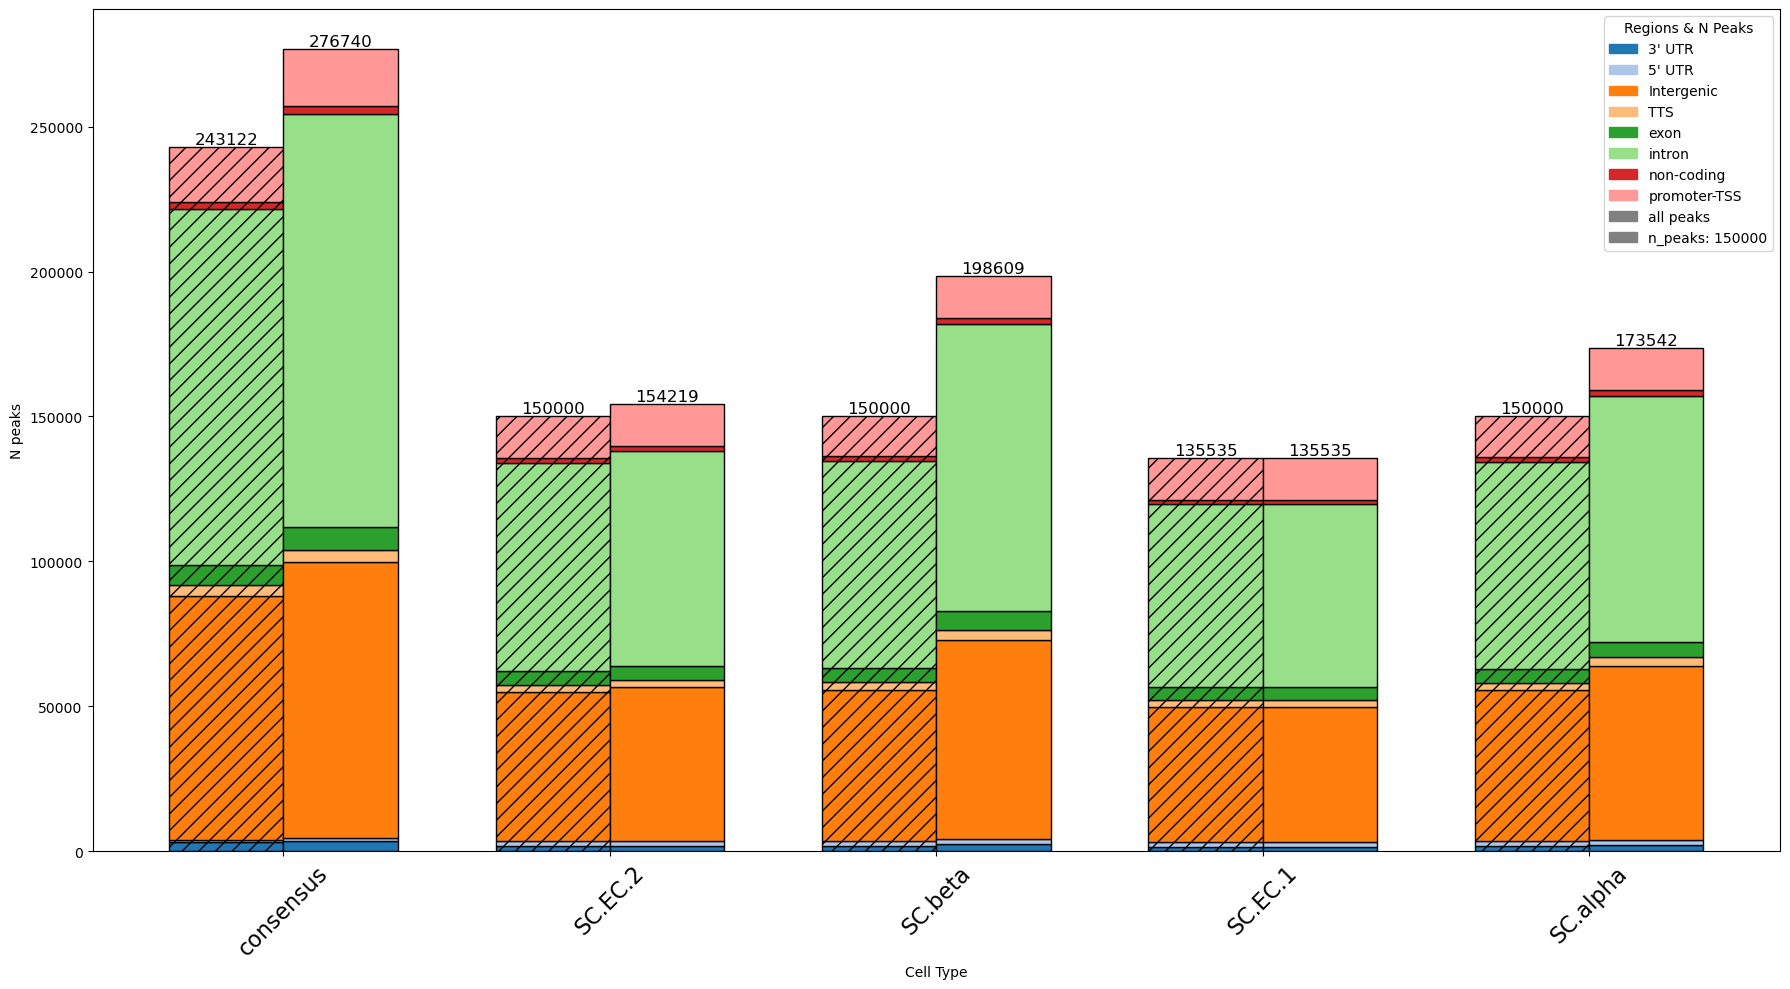

In [31]:
plot_df = annotation_counts_df.copy()
plot_df.drop("min_q_value", axis=1, inplace=True)
plot_df["n_peaks"] = plot_df["n_peaks"].astype(float).fillna('')
plot_df['n_peaks'] = pd.Categorical(plot_df['n_peaks'], categories=[150_000, ''], ordered=True)
grouped_data = plot_df.groupby(['celltype', 'n_peaks']).sum().reset_index()

# Plotting
plt.figure(figsize=(18, 10))
bar_width = 0.35  # Bar width
colors = plt.cm.tab20(range(len(plot_df.columns[:-2])))  # Colors for each genomic region

# Plot bars
for idx, celltype in enumerate(plot_df['celltype'].unique()):
    for peak_idx, n_peaks in enumerate([150_000, '']):
        subset = grouped_data[(grouped_data['celltype'] == celltype) & (grouped_data['n_peaks'] == n_peaks)]
        bottom = 0
        for color_idx, column in enumerate(plot_df.columns[:-2]):
            plt.bar(idx + peak_idx * bar_width, subset[column].values, bottom=bottom, color=colors[color_idx], 
                    width=bar_width, hatch='//' if n_peaks == 150_000 else '', edgecolor='black')
            bottom += subset[column].values[0]
        # Add total number to top of bar
        if n_peaks == 150_000:
            total = subset[plot_df.columns[:-2]].sum(axis=1).values[0]
            plt.text(idx + peak_idx * bar_width, total, total, ha='center', va='bottom', fontsize=12)
        else:
            total = subset[plot_df.columns[:-2]].sum(axis=1).values[0]
            plt.text(idx + peak_idx * bar_width, total, total, ha='center', va='bottom', fontsize=12)
        

# Labels and legend
plt.xlabel('Cell Type')
plt.ylabel('N peaks')
plt.xticks([p + bar_width/2 for p in range(len(plot_df['celltype'].unique()))], plot_df['celltype'].unique(), rotation=45, fontsize=16)

# Legend handling
region_handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(plot_df.columns[:-2]))]
n_peaks_handles = [plt.Rectangle((0,0),1,1, color='grey', hatch='//'), plt.Rectangle((0,0),1,1, color='grey')]
plt.legend(handles=region_handles + n_peaks_handles, labels=list(plot_df.columns[:-2]) + ['all peaks', 'n_peaks: 150000'], title='Regions & N Peaks')

plt.tight_layout()
plt.show()

# Slice up by distal vs promoter proximal

In [308]:
curr_df = pd.read_csv("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_control/atac/peaks/annotated/consensus.filt.annot.bed", sep="\t")
curr_df["Annotation"] = curr_df["Annotation"].str.split("(").str[0].str.strip()

In [311]:
curr_df[curr_df["Annotation"] == "promoter-TSS"]

,PeakID (cmd=annotatePeaks.pl /cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/timecourse_analysis/A2_control/atac/peaks/filtered/consensus.filt.bed hg38),Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type
10,SC.alpha-9579,chr14,104223411,104223911,+,0,NaN,promoter-TSS,promoter-TSS (NR_146611),77,NR_146611,145195.0,Hs.534297,NR_146611,ENSG00000258913,LINC02691,C14orf144,long intergenic non-protein coding RNA 2691,ncRNA
17,"SC.alpha, SC.beta, SC.EC.2-5931",chr17,58329343,58329843,+,0,NaN,promoter-TSS,promoter-TSS (NM_001261835),-12,NR_038413,100506779.0,Hs.718477,NR_038410,ENSG00000265148,TSPOAP1-AS1,BZRAP1-AS1,"TSPOAP1, SUPT4H1 and RNF43 antisense RNA 1",ncRNA
25,"SC.alpha, SC.EC.1-3808",chr22,35335434,35335934,+,0,NaN,promoter-TSS,promoter-TSS (NR_037471),44,NR_037471,100500826.0,NaN,NR_037471,ENSG00000266320,MIR3909,mir-3909,microRNA 3909,ncRNA
63,"SC.alpha, SC.beta, SC.EC.1, SC.EC.2, SC.delta-...",chr18,12702459,12702959,+,0,NaN,promoter-TSS,promoter-TSS (NM_020232),14,NM_024899,79959.0,Hs.236940,NM_024899,ENSG00000101624,CEP76,C18orf9|HsT1705,centrosomal protein 76,protein-coding
72,SC.alpha-20746,chr3,141385349,141385849,+,0,NaN,promoter-TSS,promoter-TSS (NM_001350099),-826,NM_001350099,253461.0,Hs.518301,NM_152535,ENSG00000177311,ZBTB38,CIBZ|PPP1R171|ZNF921,zinc finger and BTB domain containing 38,protein-coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399199,"SC.alpha, SC.beta, SC.EC.1, SC.EC.2, SC.delta-...",chr6,35259280,35259780,+,0,NaN,promoter-TSS,promoter-TSS (NM_003427),-205,NM_003427,7629.0,Hs.388024,NM_003427,ENSG00000065029,ZNF76,D6S229E|ZNF523|Zfp523,zinc finger protein 76,protein-coding
399216,"SC.alpha, SC.beta, SC.EC.1-436",chr1,33320781,33321281,+,0,NaN,promoter-TSS,promoter-TSS (NM_001080438),67,NM_001080438,127550.0,NaN,NM_001080438,ENSG00000184389,A3GALT2,A3GALT2P|IGB3S|IGBS3S,"alpha 1,3-galactosyltransferase 2",protein-coding
399220,"SC.alpha, SC.beta, SC.EC.2-13421",chr8,27611413,27611913,+,0,NaN,promoter-TSS,promoter-TSS (NR_045494),88,NR_045494,1191.0,Hs.436657,NM_001831,ENSG00000120885,CLU,AAG4|APO-J|APOJ|CLI|CLU1|CLU2|KUB1|NA1/NA2|SGP...,clusterin,protein-coding
399226,"SC.alpha, SC.beta, SC.EC.1, SC.EC.2, SC.delta-...",chr11,35943798,35944298,+,0,NaN,promoter-TSS,promoter-TSS (NM_174902),-14,NM_174902,143458.0,Hs.745134,NM_174902,ENSG00000179241,LDLRAD3,LRAD3,low density lipoprotein receptor class A domai...,protein-coding


Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/IPython/core/history.py", line 844, in writeout_cache
    self._writeout_input_cache(conn)
  File "/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/IPython/core/history.py", line 827, in _writeout_input_cache
    conn.execute("INSERT INTO history VALUES (?, ?, ?, ?)",
sqlite3.DatabaseError: database disk image is malformed


# FRiP score

In [ ]:
# Add consensus peaks from adata_peaks.var_names
consensus_chrom = adata_peaks.var.index.str.split(":").str[0].tolist()
consensus_start = adata_peaks.var.index.str.split(":").str[1].str.split("-").str[0].astype(int).tolist()
consensus_end = adata_peaks.var.index.str.split(":").str[1].str.split("-").str[1].astype(int).tolist()
consensus_df = pd.DataFrame({"Chromosome": consensus_chrom, "Start": consensus_start, "End": consensus_end})
consensus_pr = pr.PyRanges(consensus_df)
peaksets_pr["consensus"] = consensus_pr

In [38]:
# Fraction of reads in peaks
regions = {}
for peakset in peaksets:
    regions[peakset] = peaksets[peakset].apply(lambda x: f"{x[0]}:{x[1]}-{x[2]}", axis=1)
    regions[peakset] = regions[peakset].values

In [43]:
# Run frip
snap.metrics.frip(adataset, regions=regions, n_jobs=-1)

In [44]:
# STOPPED HERE
adata_frip = adataset.to_adata()
adata_frip.obs['annotation'] = adata_frip.obs[cell_id_col]

In [45]:
# Make frip directory
os.makedirs(os.path.join(outdir_path, "frip"), exist_ok=True)

In [47]:
frip_df = adata_frip.obs[['annotation', 'SC.EC.1', 'SC.EC.1', 'SC.alpha', 'SC.beta']]
frip_df.to_csv(os.path.join(outdir_path, "frip", "frip_per_barcode.tsv"), sep="\t")

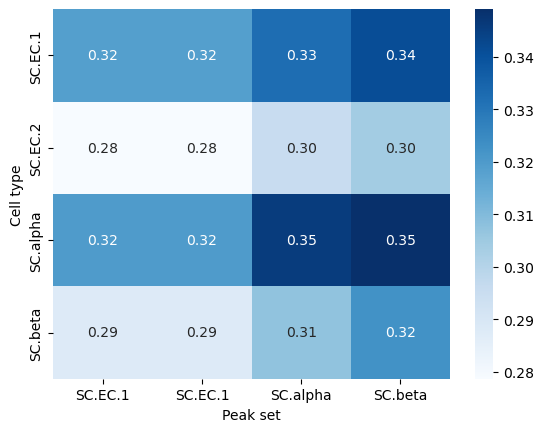

In [48]:
# For each cell type, calculate the mean FRiP for each peakset
mean_frip = frip_df.groupby("annotation").mean()

# Plot as heatmap
sns.heatmap(mean_frip, cmap="Blues", annot=True, fmt=".2f")

# X-axis label
plt.xlabel("Peak set")
plt.ylabel("Cell type")

# Save
plt.savefig(os.path.join(outdir_path, "frip", "mean_frip_heatmap.png"), bbox_inches="tight")

In [49]:
frip_df_long = frip_df.melt(id_vars=['annotation'], var_name='peakset', value_name='frip')

<Axes: xlabel='peakset', ylabel='frip'>

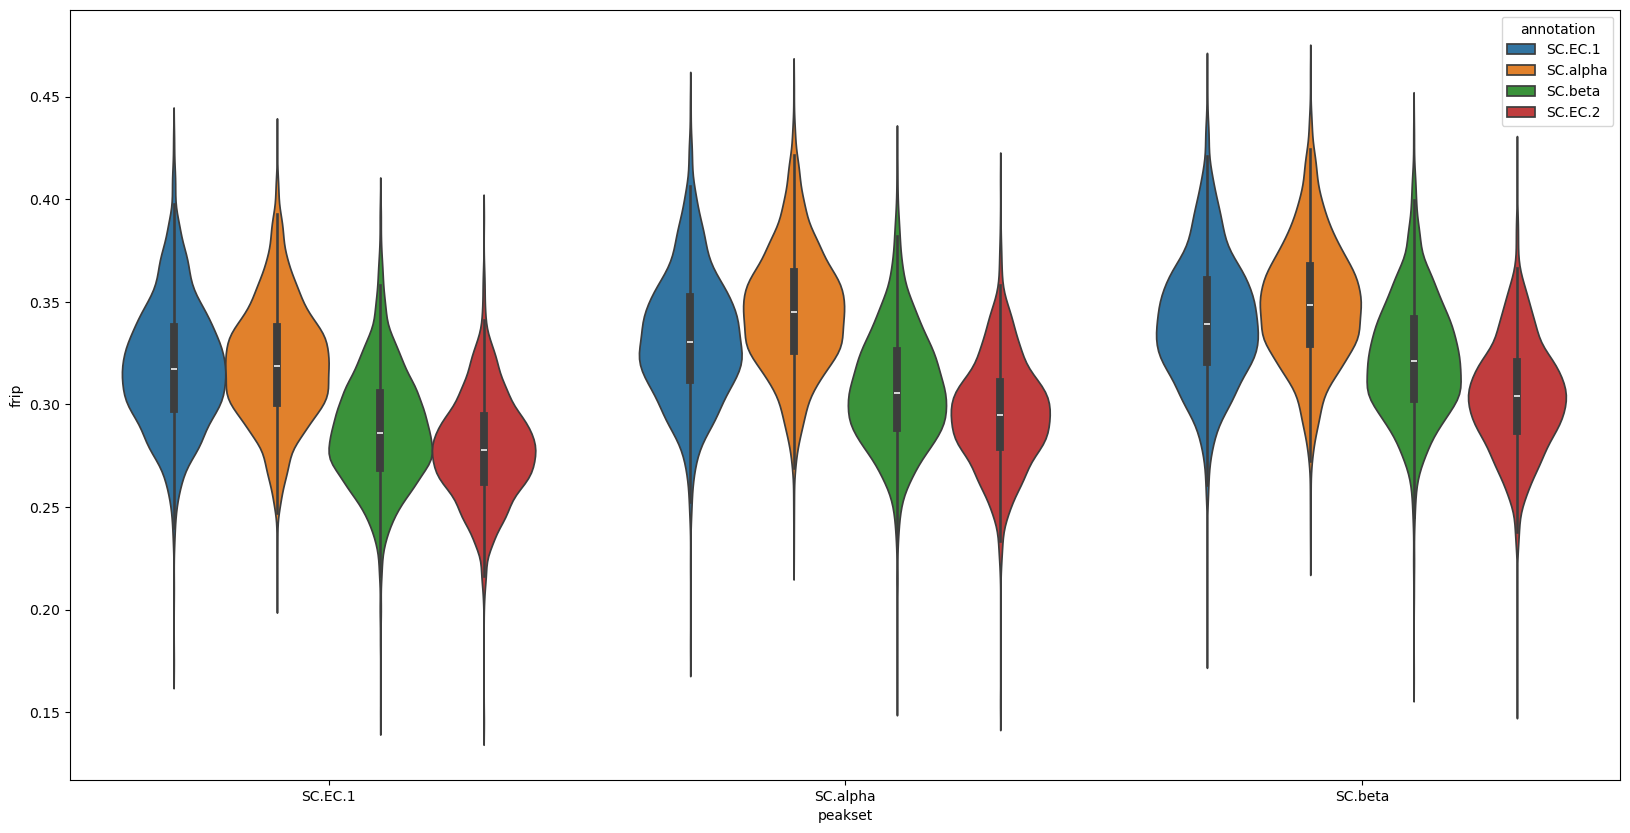

In [50]:
# Plot violin plots of frip separated by peakset
fig, ax = plt.subplots(figsize=(20, 10))
sns.violinplot(x="peakset", y="frip", hue="annotation", data=frip_df_long, ax=ax)

# Marker peaks

In [72]:
# make directory
os.makedirs(os.path.join(outdir_path, "marker_peaks"), exist_ok=True)

In [13]:
# Find marker peaks
marker_peaks = snap.tl.marker_regions(adata_peaks, groupby='annotation', pvalue=0.05)

In [14]:
marker_peaks

{'SC.EC.1': Index(['chr1:1349221-1349722', 'chr1:2467166-2467667', 'chr1:2530090-2530591',
        'chr1:2540833-2541334', 'chr1:2610972-2611473', 'chr1:3244464-3244965',
        'chr1:3431212-3431713', 'chr1:3611472-3611973', 'chr1:3624657-3625158',
        'chr1:3708807-3709308',
        ...
        'chrX:139126450-139126951', 'chrX:140503780-140504281',
        'chrX:140504324-140504825', 'chrX:141176419-141176920',
        'chrX:147911584-147912085', 'chrX:153582850-153583351',
        'chrX:153643968-153644469', 'chrX:153953274-153953775',
        'chrY:7274515-7275016', 'chrY:19015805-19016306'],
       dtype='object', length=1924),
 'SC.EC.2': Index(['chr1:1063744-1064245', 'chr1:1250108-1250609', 'chr1:1293618-1294119',
        'chr1:1420611-1421112', 'chr1:1440800-1441301', 'chr1:1462189-1462690',
        'chr1:1511279-1511780', 'chr1:1574074-1574575', 'chr1:1969008-1969509',
        'chr1:2382527-2383028',
        ...
        'chrX:135477504-135478005', 'chrX:135520888-135521

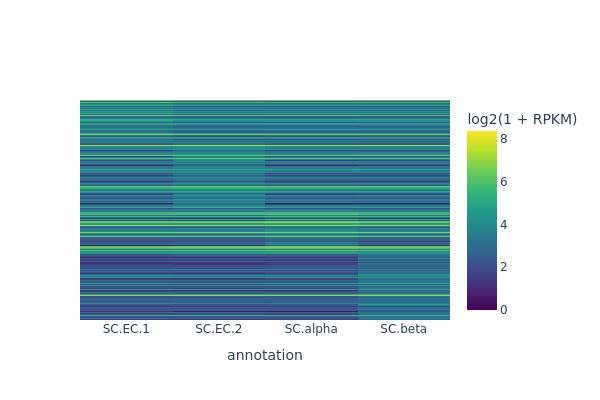

In [16]:
snap.pl.regions(adata_peaks, groupby='annotation', peaks=marker_peaks, interactive=False)#, out_file=os.path.join(outdir_path, "marker_peaks", "marker_peaks.png"))

# Peak set overlap

In [39]:
# Loop through and calculate overlap between each pair of samples
overlap_df = pd.DataFrame(columns=["sample1", "sample2", "num_overlapping_peaks", "overlap_pct", "avg_overlap_pct"])
intersect_peaks_dict = {}
intersect_frac_overlap_dict = {}
for i in range(len(peaksets_pr)):
    for j in range(len(peaksets_pr)):
        sample1, sample2 = list(peaksets_pr.keys())[i], list(peaksets_pr.keys())[j]
        if sample1 == "consensus" or sample2 == "consensus":
            continue
        sample1_peaks, sample2_peaks = peaksets_pr[sample1], peaksets_pr[sample2]
        overlap_num, overlap_pct, frac_overlap, overlap = naive_overlap(sample1_peaks, sample2_peaks, frac=0.5, return_overlap=True)
        overlap_df.loc[i*len(peaksets_pr)+j] = [sample1, sample2, overlap_num, overlap_pct, frac_overlap.mean()]
        intersect_peaks_dict[(sample1, sample2)] = overlap
        intersect_frac_overlap_dict[(sample1, sample2)] = frac_overlap

In [40]:
pct_overlap_df = overlap_df.pivot(index="sample1", columns="sample2", values="overlap_pct").astype(float)

In [41]:
# Make directory
os.makedirs(os.path.join(outdir_path, "peak_overlap"), exist_ok=True)

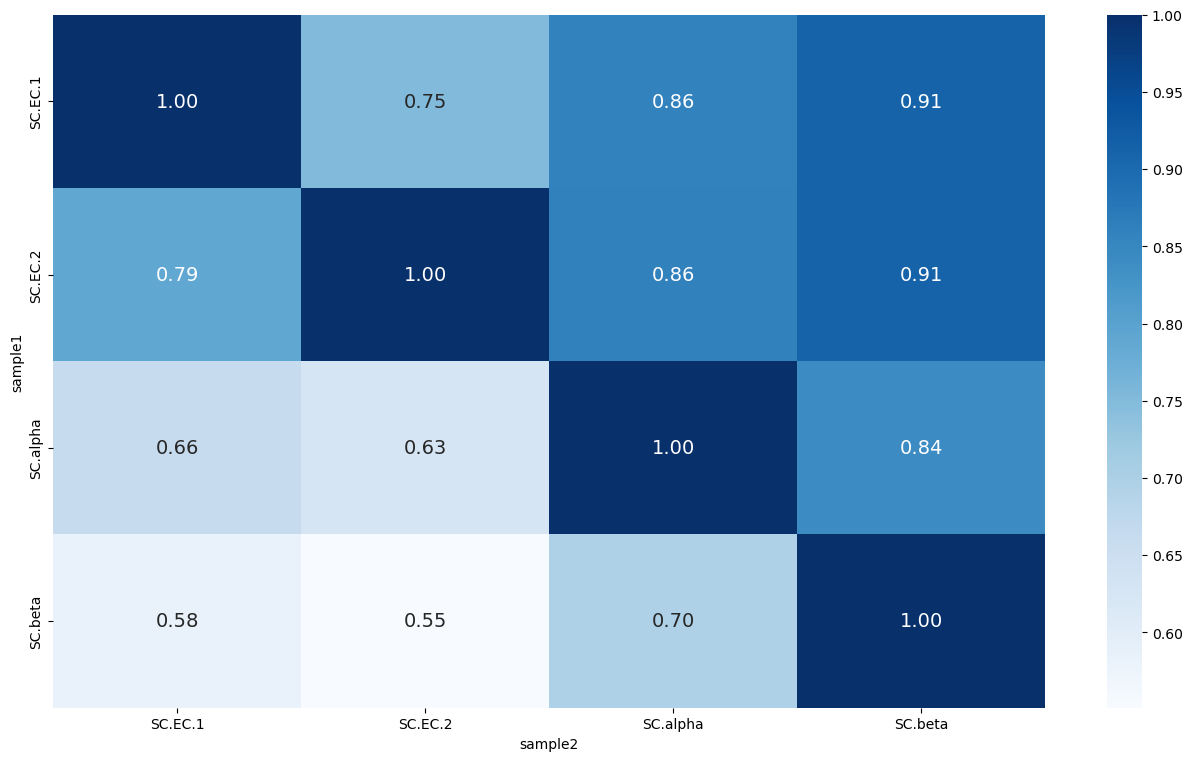

In [42]:
# Heatmap of percent of overlapping peaks, make font size smaller for annot
fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(pct_overlap_df, cmap="Blues", annot=True, fmt=".2f", ax=ax, annot_kws={"size": 14})

# Save
plt.savefig(os.path.join(outdir_path, "peak_overlap", "pct_overlap_heatmap.png"), bbox_inches="tight")

# DONE!

---

# Scratch

## Old annotation counts plot

In [ ]:
# Plot
ax = annotation_counts_df.plot.bar(stacked=True, figsize=(10, 5))
ax.set_ylabel("Number of peaks")
ax.set_xlabel("Peak annotation")
ax.set_title("Peak annotation")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Put the total number of peaks on top of each bar
total_peaks = annotation_counts_df.sum(axis=1)
for i, v in enumerate(total_peaks):
    ax.text(i, v, str(v), ha='center', va='bottom')
    
# Save
#plt.savefig(os.path.join(outdir_path, "annotated_peaks", "annotation_counts.png"), bbox_inches="tight")